# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks
### Ideation 5
### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

## <div class="theme"> Outline </div> 

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Creating Galaxy images using GalSim

## <div class="theme"> Part 1 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with fixed Sigma and PSF

### <div class='exercise'> <b> Step 0: Load the essential libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = "retina"
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

In [3]:
# Load useful libraries
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping

### <div class='exercise'> <b> Step 1: Load the dataset with fixed noise and fixed PSF </b> </div>

In [4]:
# Read the data set
dataset = "./cs109b-project/data/data_v1.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf = data["psf_r"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma', 'train_test']


<div class='gc'> <b> Join Sigma and PSF with the Label data </b> </div>

In [5]:
# Combine Singma and PSF with the label
# label = np.hstack([label, sigma.reshape(-1,1), psf.reshape(-1,1)])

### <div class='exercise'> <b> Step 2: Normalize the data and split the data into Traning and Validation sets </b> </div>

In [6]:
# Reshape images to 3D array
image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)


# Split into 90% train and 10% test (creates a view of the array)
n_train = int(label.shape[0] * 0.9)
image_train, image_val = image[:n_train], image[n_train:]
image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
label_train, label_val = label[:n_train], label[n_train:]
snr_train, snr_val = snr[:n_train], snr[n_train:]
sigma_train, sigma_val = sigma[:n_train], sigma[n_train:]
psf_train, psf_val = psf[:n_train], psf[n_train:]


# Zero-One Normalization of the labels
label_min = label.min(axis=0)
label_max = label.max(axis=0)
label_diff = np.maximum((label_max - label_min),1e-10)

label_train = (label_train - label_min)/label_diff
label_val = (label_val - label_min)/label_diff


# Zero-One Normalization of the no-noise images
image_nonoise_min = image_nonoise.min()
image_nonoise_max = image_nonoise.max()
image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


# Zero-One Normalization of the noisy images
image_min = image.min()
image_max = image.max()
image_diff = (image_max - image_min)

image_train = (image_train - image_min)/image_diff
image_val = (image_val - image_min)/image_diff


# Compute Image Statistics
stats = np.hstack([image.mean(axis=(1,2)).reshape(-1,1), image.std(axis=(1,2)).reshape(-1,1)])
stats_train, stats_val = stats[:n_train], stats[n_train:]

### <div class='exercise'> <b> Step 3: Structure and Size of the Data </b> </div>

In [7]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))
print("Stats Shape            = {}".format(stats.shape))

Image Shape            = (200000, 64, 64, 1)
No-noise Image Shape   = (200000, 64, 64, 1)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Stats Shape            = (200000, 2)


### <div class='exercise'> <b> Step 4: Create Data Pipeline </b> </div>

<div class='gc'> <b> Create Tensorflow Dataset </b> </div>

In [8]:
# Create Tensorflow Dataset
training = tf.data.Dataset.from_tensor_slices({
    "Image": image_train,
    "No-noise Image": image_nonoise_train,
    "Labels": label_train,
    "Stats": stats_train
})

validation = tf.data.Dataset.from_tensor_slices({
    "Image": image_val,
    "No-noise Image": image_nonoise_val,
    "Labels": label_val,
    "Stats": stats_val
})

<div class='gc'> <b> Define pipeline functions to structure dataset </b> </div>

In [9]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((label, stats), image)

In [10]:
def pipeline_noisy_image_to_label(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((image, stats), label)

In [11]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    clean = element['No-noise Image']
    
    return ((image, stats), (clean, label))

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [12]:
# Batch Size
batch_size = 256


# Data pipeline for Decoder
tr_ds = training.map(
    pipeline_label_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = validation.map(
    pipeline_label_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Data pipeline for Encoder
tr_ds_en = training.map(
    pipeline_noisy_image_to_label).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_en = validation.map(
    pipeline_noisy_image_to_label).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Data pipeline for AE
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 5: Create Convolution Encoders and Decoder </b> </div>

<div class='gc'> <b> Declare global model parameters </b> </div>

In [13]:
K.clear_session()

# Encoder Inout Dimension
input_shape_img = (64,64,1)
input_shape_stats = (2,)

# Dropout rate for dense layers
dropout = 0.5

# Encoder Output dimension - Decoder Input Dimension
latent_z_dim_labels = 5
latent_z_dim_stats = 2

# Decoder latent dimension
latent_dim = (1,1,2048)

# Number of Training Epochs
epochs = 50

<div class='gc'> <b> Define convolution encoder </b> </div>

In [14]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        ## your code here
        
        self.conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.conv3 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.conv4 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.conv5 = layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.conv6 = layers.Conv2D(filters=2048, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu6 = layers.LeakyReLU()
        self.drop6 = layers.Dropout(dropout_rate)
        
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        z = self.conv1(inputs)
        z = self.lRelu1(z)
        z = self.drop1(z)
        
        z = self.conv2(z)
        z = self.lRelu2(z)
        z = self.drop2(z)
        
        z = self.conv3(z)
        z = self.lRelu3(z)
        z = self.drop3(z)
        
        z = self.conv4(z)
        z = self.lRelu4(z)
        z = self.drop4(z)
        
        z = self.conv5(z)
        z = self.lRelu5(z)
        z = self.drop5(z)
        
        z = self.conv6(z)
        z = self.lRelu6(z)
        z = self.drop6(z)
        
        # end of your code here
        return z

<div class='gc'> <b> Define convolution decoder </b> </div>

In [15]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        # your code here
        self.convT1 = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.convT2 = layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.convT3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.convT4 = layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.convT5 = layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.convT6 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same', 
                                             activation='sigmoid')
        # end of your code here
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        ## your code here
        
        x = self.convT1(inputs)
        x = self.lRelu1(x)
        x = self.drop1(x)
        
        x = self.convT2(x)
        x = self.lRelu2(x)
        x = self.drop2(x)
        
        x = self.convT3(x)
        x = self.lRelu3(x)
        x = self.drop3(x)
        
        x = self.convT4(x)
        x = self.lRelu4(x)
        x = self.drop4(x)
        
        x = self.convT5(x)
        x = self.lRelu5(x)
        x = self.drop5(x)
        
        x = self.convT6(x)
        
        # end your code here
        return x

### <div class='exercise'> <b> Step 5: Create Conditional Auto-encoder </b> </div>

<div class='gc'> <b> Create Label to Image Decoder </b> </div>

In [16]:
# Create Reverse Decoder Model
def create_reverse_decoder():

    # Create Reverse Decoder
    input_decoder_labels = layers.Input(latent_z_dim_labels)
    #input_decoder_stats = layers.Input(latent_z_dim_stats)
    
    #x = layers.concatenate([input_decoder_labels, input_decoder_stats])
    
    x = layers.Dense(1024)(input_decoder_labels)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    # Decoder Model
    #decoder = tf.keras.Model([input_decoder_labels, input_decoder_stats], recon, name='Reverse_Decoder')
    decoder = tf.keras.Model(input_decoder_labels, recon, name='Reverse_Decoder')
    display(decoder.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    decoder.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return reverse decoder
    return decoder

reverse_decoder = create_reverse_decoder()

Model: "Reverse_Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 2048)    

None

<div class='gc'> <b> Create Image to Label Encoder conditional on Images Statistics</b> </div>

In [17]:
# Create Reverse Decoder Model
def create_reverse_encoder():

    # Create Reverse Encoder
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    x = ConvEncoder(input_shape_img)(input_encoder_img)
    x = layers.Flatten()(x)
    
    x = layers.concatenate([x, input_encoder_stats])
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1024)(x)
    x = layers.Dropout(dropout)(x)
    
    latent_z = layers.Dense(latent_z_dim_labels, activation='sigmoid')(x)
    
    
    # Encoder Model
    encoder = tf.keras.Model([input_encoder_img, input_encoder_stats], latent_z, name='Reverse_Encoder')
    display(encoder.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.001)
    encoder.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return reverse decoder
    return encoder

reverse_encoder = create_reverse_encoder()

Model: "Reverse_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 1, 1, 2048)   11007232    input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           encoder[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
____________________________________________________________________________________

None

<div class='gc'> <b> Create Noisy image to Clean image and Label Auto-encoder conditional on image statistics</b> </div>

In [18]:
def create_reverse_AE():
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    labels = reverse_encoder([input_encoder_img, input_encoder_stats])
    recons = reverse_decoder(labels)
    
    # Reverse AE Model
    reverse_AE = tf.keras.Model([input_encoder_img, input_encoder_stats], [recons, labels], name='Reverse_AE')
    display(reverse_AE.summary())
    
    # Compile the model
    optimizer = optimizers.Adam(learning_rate=0.0001)
    reverse_AE.compile(optimizer, loss=losses.BinaryCrossentropy())
    
    # Return reverse decoder
    return reverse_AE

reverse_AE = create_reverse_AE()

Model: "Reverse_AE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
Reverse_Encoder (Model)         (None, 5)            17310981    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Reverse_Decoder (Model)         (None, 64, 64, 1)    13110529    Reverse_Encoder[1][0]   

None

### <div class='exercise'> <b> Step 6: Training Conditional Auto-encoder on Image Dataset with fixed noise and PSF</b> </div>

<div class='gc'> <b> Traning conditional decoder</b> </div>

In [19]:
# Run the model
try:
    reverse_decoder.load_weights('./model/rev_de6_1')
    print("Training Loss:   {:0.5f}".format(reverse_decoder.evaluate(tr_ds)))
    print("Validation Loss: {:0.5f}".format(reverse_decoder.evaluate(val_ds)))
    
except:
    history = reverse_decoder.fit(
        tr_ds, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_decoder.save_weights('./model/rev_de6_1')

704/704 [==============================] - 114s 162ms/step - loss: 0.0120
Training Loss:   0.01199
79/79 [==============================] - 12s 158ms/step - loss: 0.0121
Validation Loss: 0.01207


<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [20]:
test = val_ds.take(1)
labels, images = next(iter(test))
pred = reverse_decoder.predict(labels)
pred = pred.reshape(pred.shape[:-1])

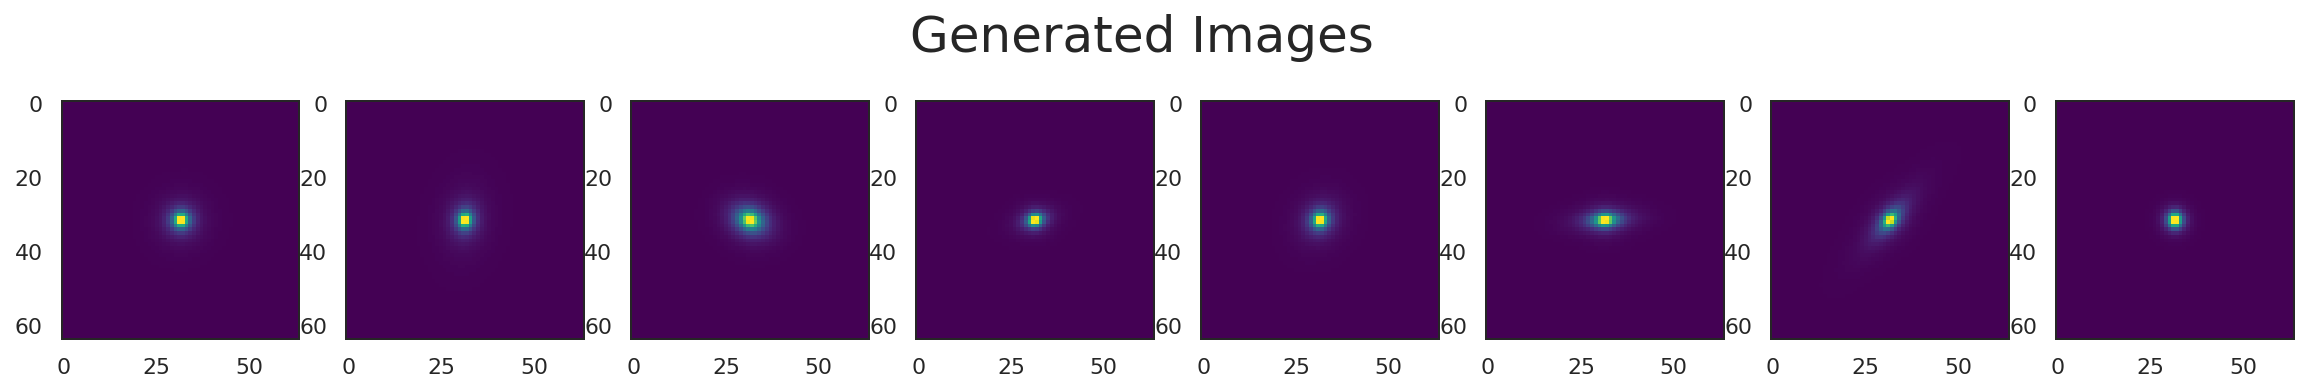

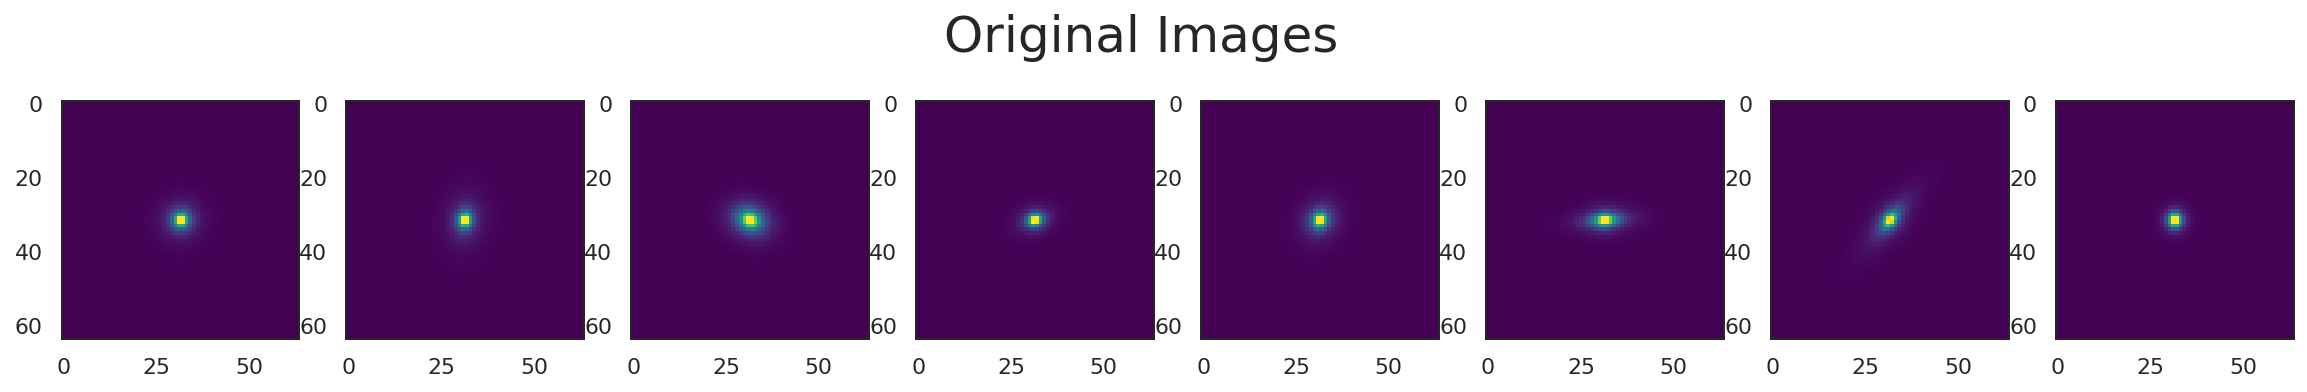

In [21]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Traning conditional encoder</b> </div>

In [22]:
# Run the model
try:
    reverse_encoder.load_weights('./model/rev_en6_1')
    print("Training Loss:   {:0.5f}".format(reverse_encoder.evaluate(tr_ds_en)))
    print("Validation Loss: {:0.5f}".format(reverse_encoder.evaluate(val_ds_en)))
    
except:
    history = reverse_encoder.fit(
        tr_ds_en, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_en,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_encoder.save_weights('./model/rev_en6_1')

704/704 [==============================] - 19s 27ms/step - loss: 0.5654
Training Loss:   0.56540
79/79 [==============================] - 2s 28ms/step - loss: 0.5665
Validation Loss: 0.56646


<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [23]:
test = val_ds_en.take(1)
images, labels = next(iter(test))
pred = reverse_encoder.predict(images)

In [24]:
np.set_printoptions(suppress=True)

for i in idx:
    print("Pred:    ", tuple(pred[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.37108535, 0.5618347, 0.74605507, 0.50600666, 0.49685055)
Orignal:  (0.34643662, 0.5525526, 0.6912154, 0.49328083, 0.48106822)
Error:    (0.024648726, 0.009282112, 0.05483967, 0.01272583, 0.015782326)

###########################################################################################

Pred:     (0.24987528, 0.62893385, 0.793604, 0.35832486, 0.4232266)
Orignal:  (0.2742813, 0.997998, 0.99534243, 0.29677868, 0.44101024)
Error:    (-0.024406016, -0.36906415, -0.20173842, 0.061546177, -0.017783642)

###########################################################################################

Pred:     (0.0834381, 0.22201827, 0.7947384, 0.5998608, 0.60383105)
Orignal:  (0.080531046, 0.16516517, 0.983407, 0.58851045, 0.59688056)
Error:    (0.0029070526, 0.0568531, -0.18866861, 0.011350334, 0.0069504976)

###########################################################################################

Pred:     (0.40191627, 0.7709266, 0.116360635, 0.7901698, 0.31210512)
Orignal

<div class='gc'> <b> Variance Analysis </b> </div>

In [25]:
pred = reverse_encoder.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (6247.438, 0.7900205, 0.047786534, 0.07518807, 0.08265053)
Unexplained Variance:  (0.016427817, 0.24617444, 0.11548437, 0.07256082, 0.08878297)
Explained Variance:    (0.9835722, 0.75382555, 0.88451564, 0.9274392, 0.91121703)


<div class='gc'> <b> Finetuning Conditional Auto-encoder </b> </div>

In [26]:
# Run the model
try:
    reverse_AE.load_weights('./model/rev_AE6_1')
    print("Training Loss:   {}".format(reverse_AE.evaluate(tr_ds_AE)))
    print("Validation Loss: {}".format(reverse_AE.evaluate(val_ds_AE)))
    
except:
    history = reverse_AE.fit(
        tr_ds_AE, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_AE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_AE.save_weights('./model/rev_AE6_1')

704/704 [==============================] - 129s 183ms/step - loss: 0.5755 - Reverse_Decoder_loss: 0.0120 - Reverse_Encoder_loss: 0.5635
Training Loss:   [0.5754912603138522, 0.012019022, 0.56347233]
79/79 [==============================] - 14s 181ms/step - loss: 0.5775 - Reverse_Decoder_loss: 0.0121 - Reverse_Encoder_loss: 0.5654
Validation Loss: [0.577501706684692, 0.012093837, 0.56540793]


<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [27]:
test = val_ds_AE.take(1)
(images, stats), (clean, labels) = next(iter(test))
pred_img, pred_lab = reverse_AE.predict([images, stats])
pred = pred_img.reshape(pred_img.shape[:-1])

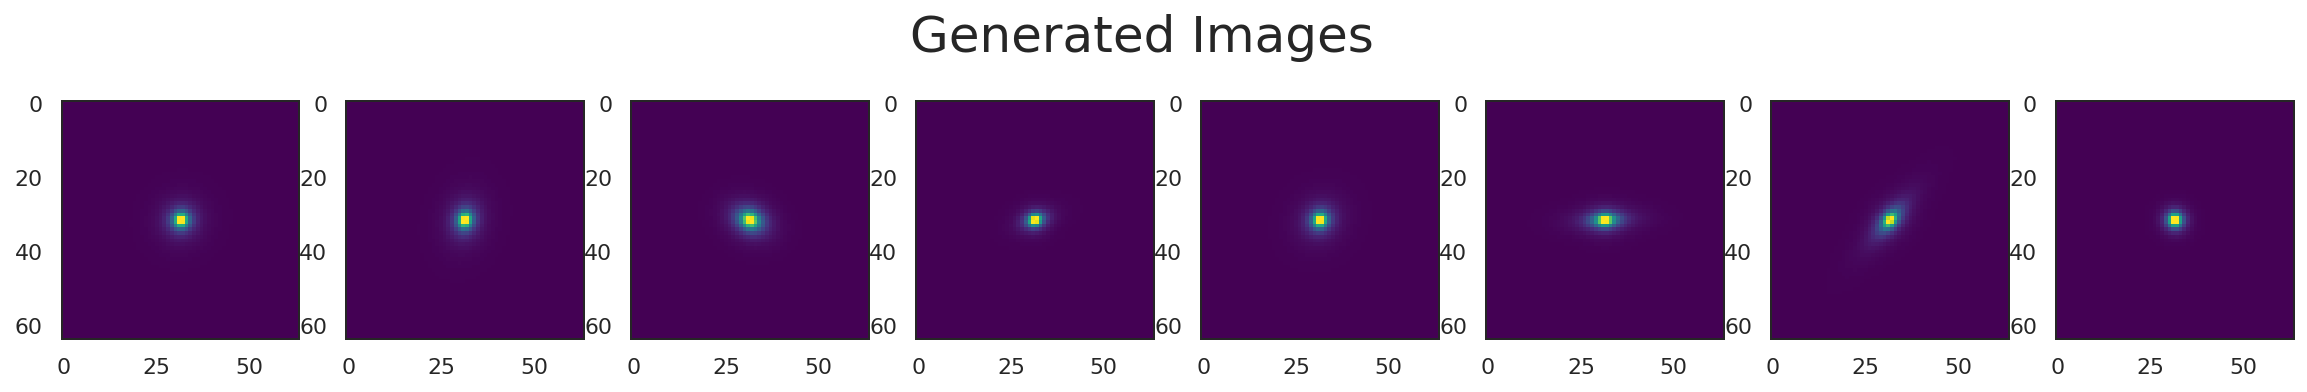

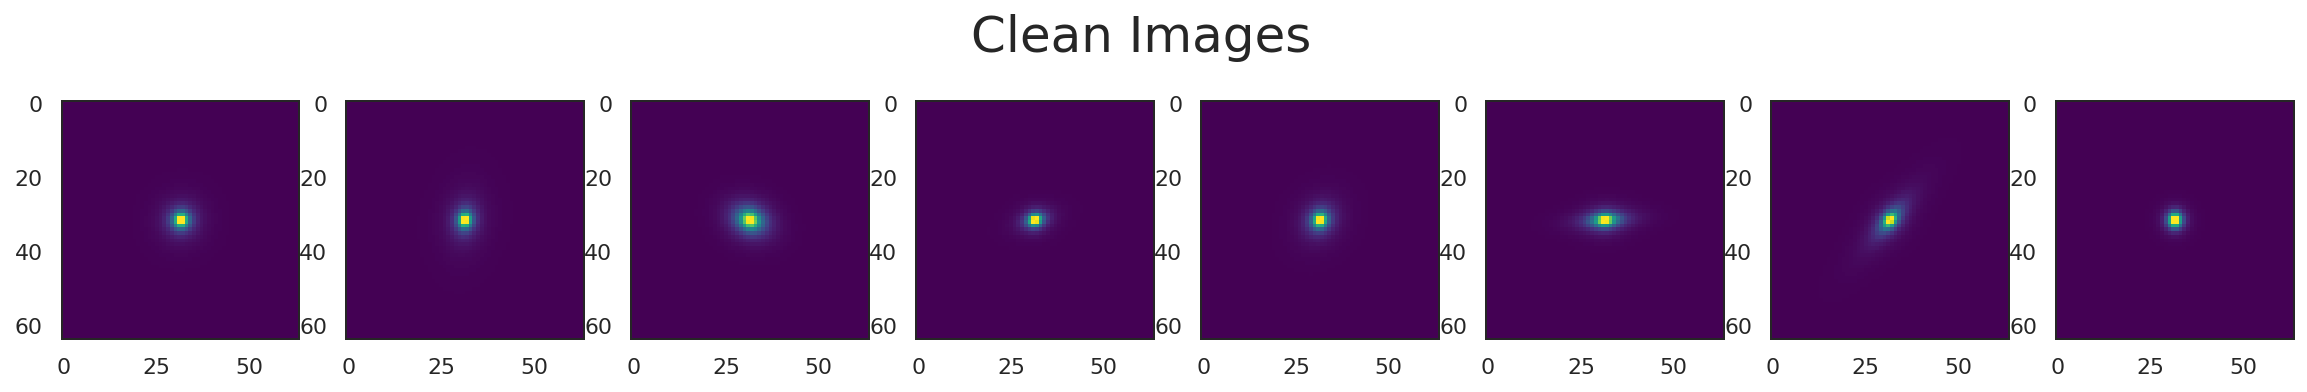

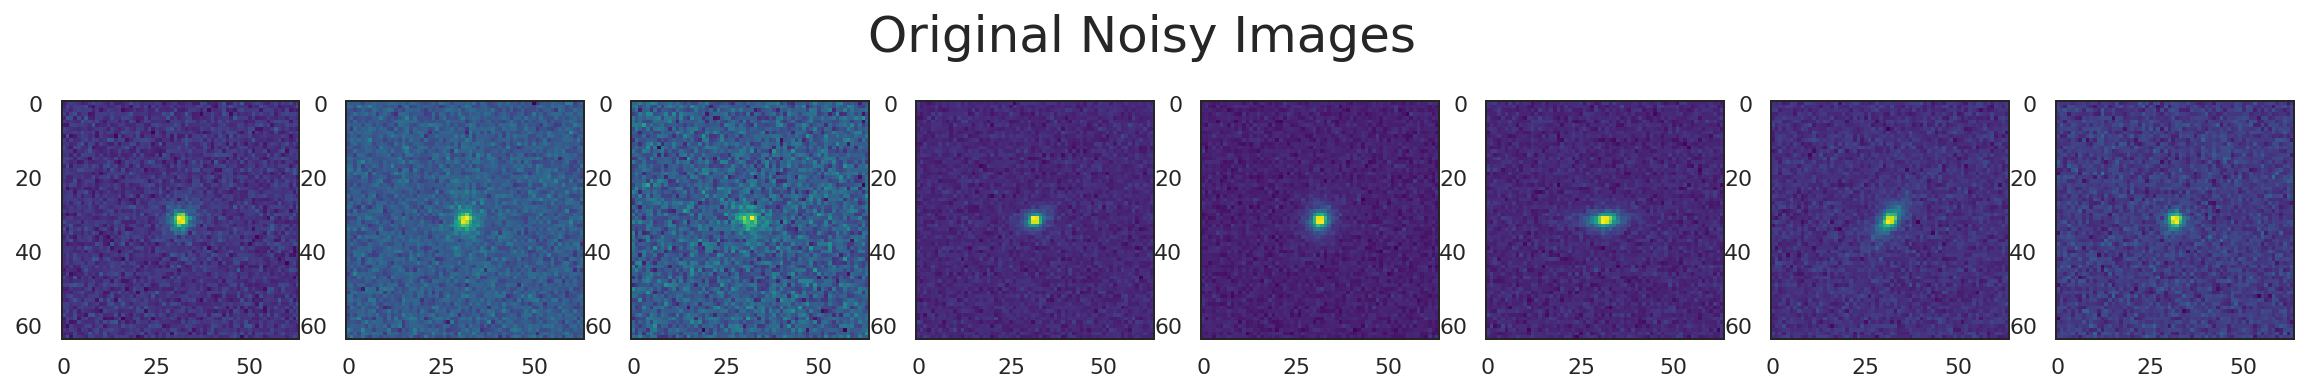

In [28]:
fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Clean Images", fontsize=25)
for j in range(8):
    ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
plt.show()

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Noisy Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [29]:
for i in idx:
    print("Pred:    ", tuple(pred_lab[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred_lab[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.37123644, 0.5885267, 0.7621595, 0.49377355, 0.4682191)
Orignal:  (0.34643662, 0.5525526, 0.6912154, 0.49328083, 0.48106822)
Error:    (0.024799824, 0.035974145, 0.07094413, 0.0004927218, -0.012849122)

###########################################################################################

Pred:     (0.2502868, 0.6579491, 0.84247553, 0.35183293, 0.4240157)
Orignal:  (0.2742813, 0.997998, 0.99534243, 0.29677868, 0.44101024)
Error:    (-0.023994505, -0.3400489, -0.1528669, 0.055054247, -0.016994536)

###########################################################################################

Pred:     (0.06796488, 0.21318242, 0.82407165, 0.59195745, 0.62204593)
Orignal:  (0.080531046, 0.16516517, 0.983407, 0.58851045, 0.59688056)
Error:    (-0.012566164, 0.04801725, -0.15933537, 0.0034469962, 0.025165379)

###########################################################################################

Pred:     (0.37897786, 0.76323915, 0.10165498, 0.8004447, 0.27435938)
Orig

<div class='gc'> <b> Variance Analysis </b> </div>

In [30]:
_, pred = reverse_AE.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (5988.438, 0.7783188, 0.046738245, 0.073699646, 0.07397799)
Unexplained Variance:  (0.015093956, 0.23893584, 0.11047321, 0.06971642, 0.07112848)
Explained Variance:    (0.984906, 0.7610642, 0.8895268, 0.9302836, 0.9288715)


## <div class="theme"> End of Part 1 </div> 

## <div class="theme"> Part 2 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and fixed PSF

### <div class='exercise'> <b> Step 1: Load the dataset with variable noise and fixed PSF </b> </div>

In [31]:
# Read the data set
dataset = "./cs109b-project/data/data_v2.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf = data["psf_r"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma', 'train_test']


<div class='gc'> <b> Join Sigma and PSF with the Label data </b> </div>

In [32]:
# Combine Singma and PSF with the label
# label = np.hstack([label, sigma.reshape(-1,1), psf.reshape(-1,1)])

### <div class='exercise'> <b> Step 2: Normalize the data and split the data into Traning and Validation sets </b> </div>

In [33]:
# Reshape images to 3D array
image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)


# Split into 90% train and 10% test (creates a view of the array)
n_train = int(label.shape[0] * 0.9)
image_train, image_val = image[:n_train], image[n_train:]
image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
label_train, label_val = label[:n_train], label[n_train:]
snr_train, snr_val = snr[:n_train], snr[n_train:]
sigma_train, sigma_val = sigma[:n_train], sigma[n_train:]
psf_train, psf_val = psf[:n_train], psf[n_train:]


# Zero-One Normalization of the labels
label_min = label.min(axis=0)
label_max = label.max(axis=0)
label_diff = np.maximum((label_max - label_min),1e-10)

label_train = (label_train - label_min)/label_diff
label_val = (label_val - label_min)/label_diff


# Zero-One Normalization of the no-noise images
image_nonoise_min = image_nonoise.min()
image_nonoise_max = image_nonoise.max()
image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


# Zero-One Normalization of the noisy images
image_min = image.min()
image_max = image.max()
image_diff = (image_max - image_min)

image_train = (image_train - image_min)/image_diff
image_val = (image_val - image_min)/image_diff


# Compute Image Statistics
stats = np.hstack([image.mean(axis=(1,2)).reshape(-1,1), image.std(axis=(1,2)).reshape(-1,1)])
stats_train, stats_val = stats[:n_train], stats[n_train:]

### <div class='exercise'> <b> Step 3: Structure and Size of the Data </b> </div>

In [34]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))
print("Stats Shape            = {}".format(stats.shape))

Image Shape            = (200000, 64, 64, 1)
No-noise Image Shape   = (200000, 64, 64, 1)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Stats Shape            = (200000, 2)


### <div class='exercise'> <b> Step 4: Create Data Pipeline </b> </div>

<div class='gc'> <b> Create Tensorflow Dataset </b> </div>

In [35]:
# Create Tensorflow Dataset
training = tf.data.Dataset.from_tensor_slices({
    "Image": image_train,
    "No-noise Image": image_nonoise_train,
    "Labels": label_train,
    "Stats": stats_train
})

validation = tf.data.Dataset.from_tensor_slices({
    "Image": image_val,
    "No-noise Image": image_nonoise_val,
    "Labels": label_val,
    "Stats": stats_val
})

<div class='gc'> <b> Define pipeline functions to structure dataset </b> </div>

In [36]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((label, stats), image)

In [37]:
def pipeline_noisy_image_to_label(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((image, stats), label)

In [38]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    clean = element['No-noise Image']
    
    return ((image, stats), (clean, label))

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [39]:
# Batch Size
batch_size = 256


# Data pipeline for Decoder
tr_ds = training.map(
    pipeline_label_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = validation.map(
    pipeline_label_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Data pipeline for Encoder
tr_ds_en = training.map(
    pipeline_noisy_image_to_label).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_en = validation.map(
    pipeline_noisy_image_to_label).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Data pipeline for AE
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 6: Training Conditional Auto-encoder on Image Dataset with variable noise and fixed PSF</b> </div>

<div class='gc'> <b> Traning conditional decoder</b> </div>

In [40]:
# Run the model
try:
    reverse_decoder.load_weights('./model/rev_de6_2')
    print("Training Loss:   {:0.5f}".format(reverse_decoder.evaluate(tr_ds)))
    print("Validation Loss: {:0.5f}".format(reverse_decoder.evaluate(val_ds)))
    
except:
    history = reverse_decoder.fit(
        tr_ds, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_decoder.save_weights('./model/rev_de6_2')

704/704 [==============================] - 112s 159ms/step - loss: 0.0095
Training Loss:   0.00954
79/79 [==============================] - 13s 159ms/step - loss: 0.0095
Validation Loss: 0.00953


<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [41]:
test = val_ds.take(1)
labels, images = next(iter(test))
pred = reverse_decoder.predict(labels)
pred = pred.reshape(pred.shape[:-1])

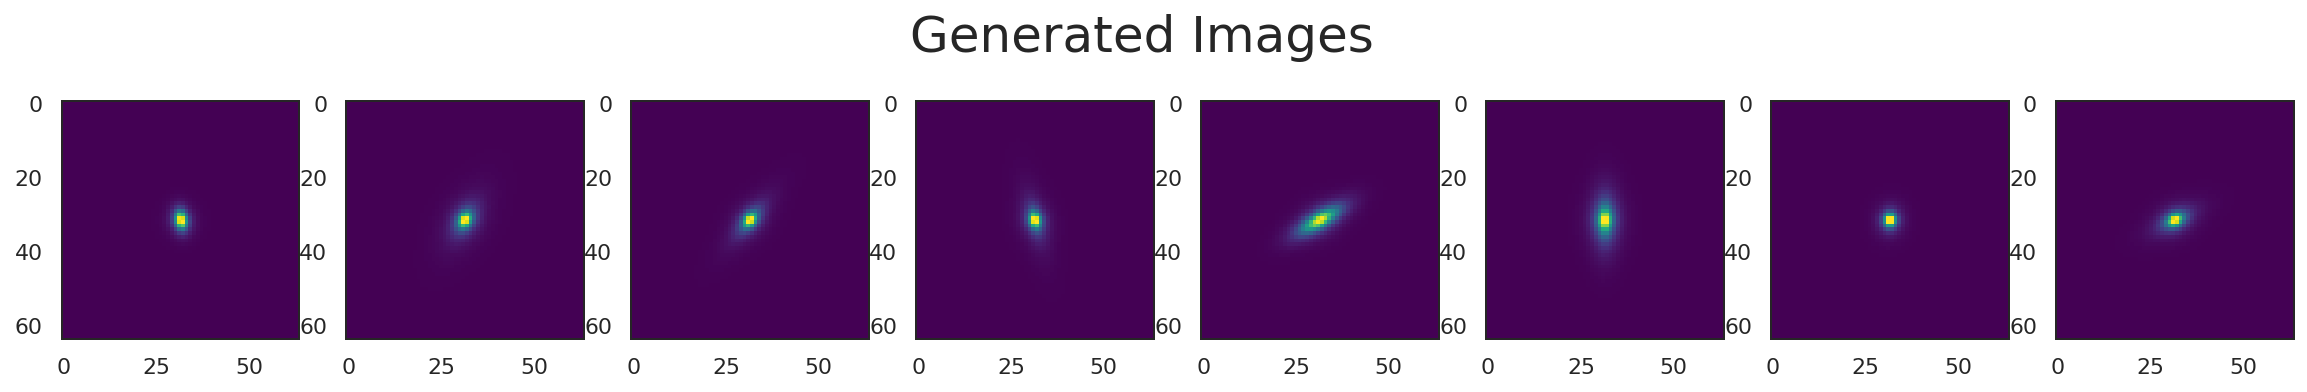

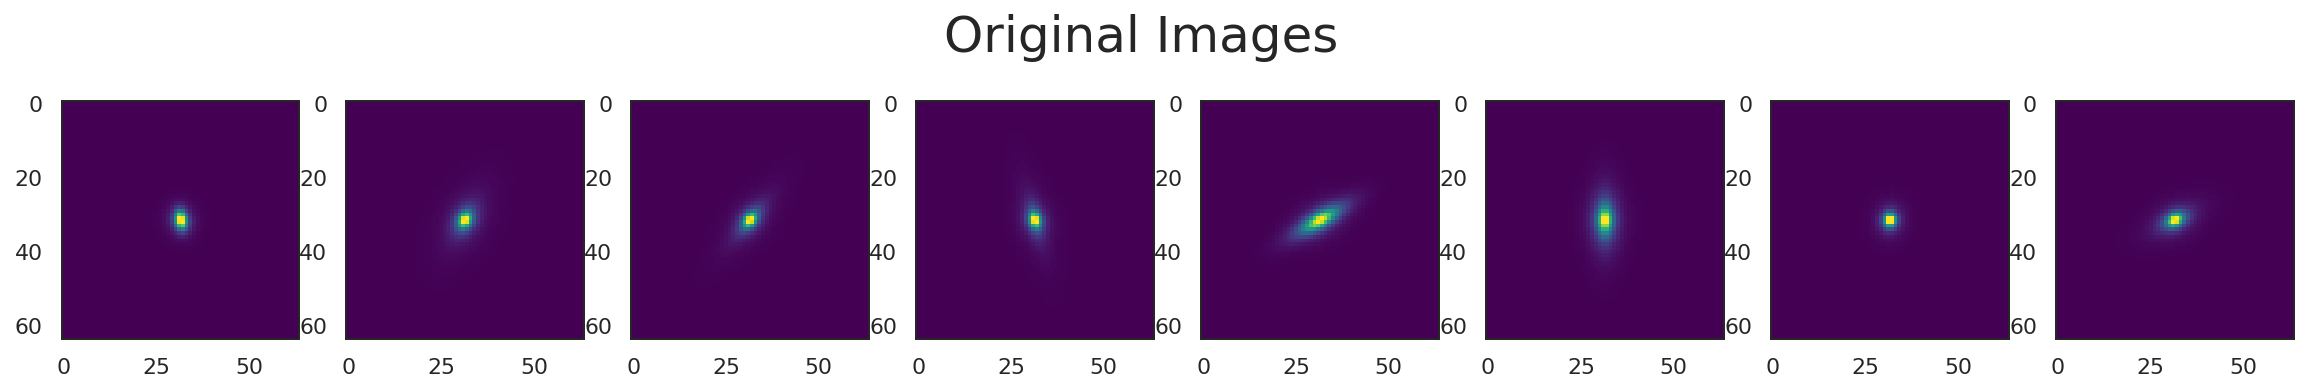

In [42]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Traning conditional encoder</b> </div>

In [43]:
# Run the model
try:
    reverse_encoder.load_weights('./model/rev_en6_2')
    print("Training Loss:   {:0.5f}".format(reverse_encoder.evaluate(tr_ds_en)))
    print("Validation Loss: {:0.5f}".format(reverse_encoder.evaluate(val_ds_en)))
    
except:
    history = reverse_encoder.fit(
        tr_ds_en, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_en,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_encoder.save_weights('./model/rev_en6_2')

704/704 [==============================] - 19s 27ms/step - loss: 0.5762
Training Loss:   0.57623
79/79 [==============================] - 2s 25ms/step - loss: 0.5760
Validation Loss: 0.57604


<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [44]:
test = val_ds_en.take(1)
images, labels = next(iter(test))
pred = reverse_encoder.predict(images)

In [45]:
np.set_printoptions(suppress=True)

for i in idx:
    print("Pred:    ", tuple(pred[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.19049487, 0.1887295, 0.24935654, 0.24234194, 0.5423153)
Orignal:  (0.17026287, 0.049049053, 0.18080983, 0.10208102, 0.6493643)
Error:    (0.020231992, 0.13968045, 0.06854671, 0.1402609, -0.10704899)

###########################################################################################

Pred:     (0.32882613, 0.54710746, 0.8239063, 0.40822676, 0.24912423)
Orignal:  (0.3362047, 0.5925926, 0.8538069, 0.34280568, 0.24744813)
Error:    (-0.007378578, -0.04548514, -0.02990061, 0.065421075, 0.0016760975)

###########################################################################################

Pred:     (0.56775934, 0.7200306, 0.7456638, 0.45188838, 0.069365144)
Orignal:  (0.51807296, 0.5695696, 0.5238198, 0.4018364, 0.055329215)
Error:    (0.049686372, 0.15046102, 0.22184402, 0.050051987, 0.014035929)

###########################################################################################

Pred:     (0.29375803, 0.71814036, 0.6533982, 0.19165954, 0.6944391)
Orignal:

<div class='gc'> <b> Variance Analysis </b> </div>

In [46]:
pred = reverse_encoder.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (12433.268, 0.9608945, 0.0654644, 0.11536887, 0.10592806)
Unexplained Variance:  (0.023350202, 0.3641813, 0.21598414, 0.17393033, 0.14410904)
Explained Variance:    (0.9766498, 0.6358187, 0.7840159, 0.82606965, 0.855891)


<div class='gc'> <b> Finetuning Conditional Auto-encoder </b> </div>

In [47]:
# Run the model
try:
    reverse_AE.load_weights('./model/rev_AE6_2')
    print("Training Loss:   {}".format(reverse_AE.evaluate(tr_ds_AE)))
    print("Validation Loss: {}".format(reverse_AE.evaluate(val_ds_AE)))
    
except:
    history = reverse_AE.fit(
        tr_ds_AE, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_AE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_AE.save_weights('./model/rev_AE6_2')

704/704 [==============================] - 130s 184ms/step - loss: 0.5751 - Reverse_Decoder_loss: 0.0096 - Reverse_Encoder_loss: 0.5655
Training Loss:   [0.5750916324217211, 0.00955961, 0.56553155]
79/79 [==============================] - 14s 181ms/step - loss: 0.5754 - Reverse_Decoder_loss: 0.0096 - Reverse_Encoder_loss: 0.5658
Validation Loss: [0.5754005984414982, 0.0095521435, 0.56584835]


<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [48]:
test = val_ds_AE.take(1)
(images, stats), (clean, labels) = next(iter(test))
pred_img, pred_lab = reverse_AE.predict([images, stats])
pred = pred_img.reshape(pred_img.shape[:-1])

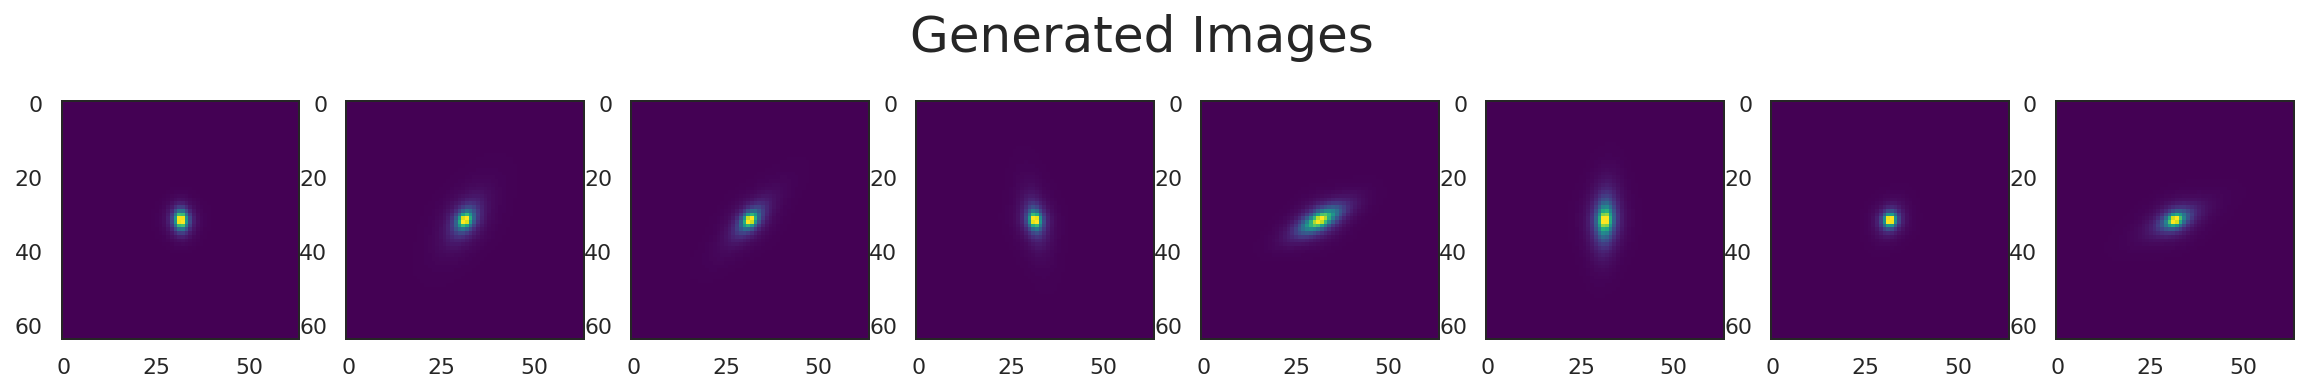

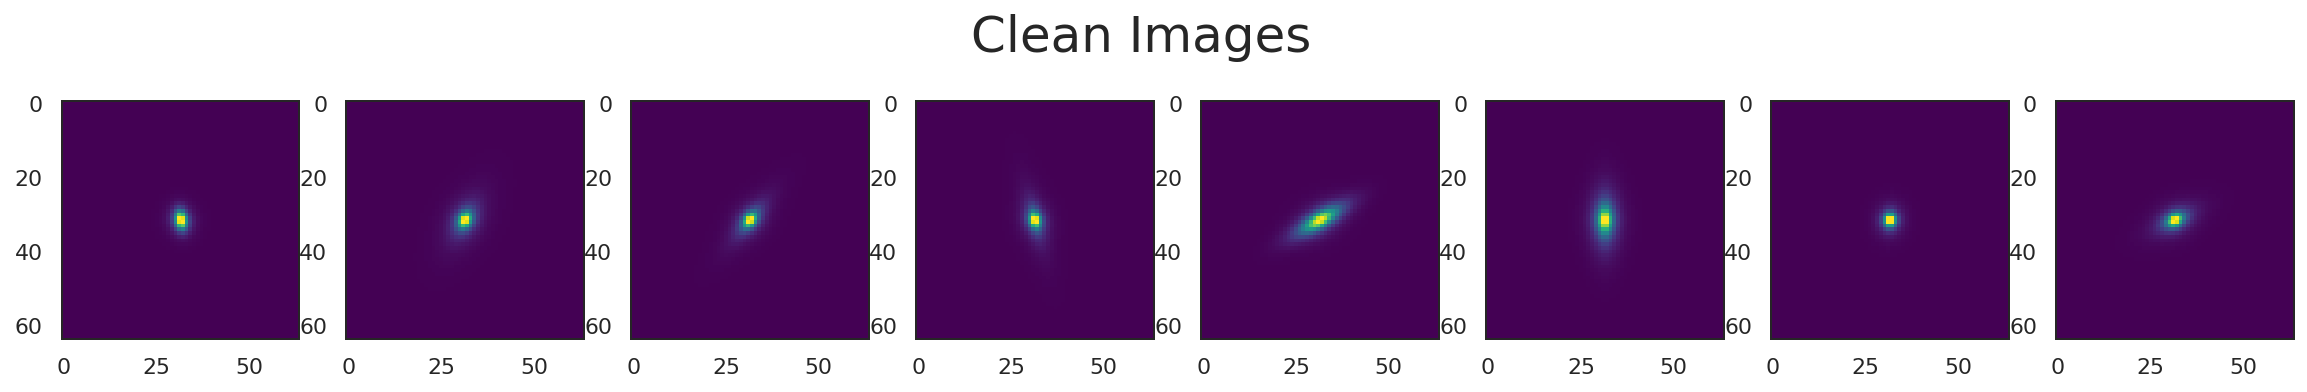

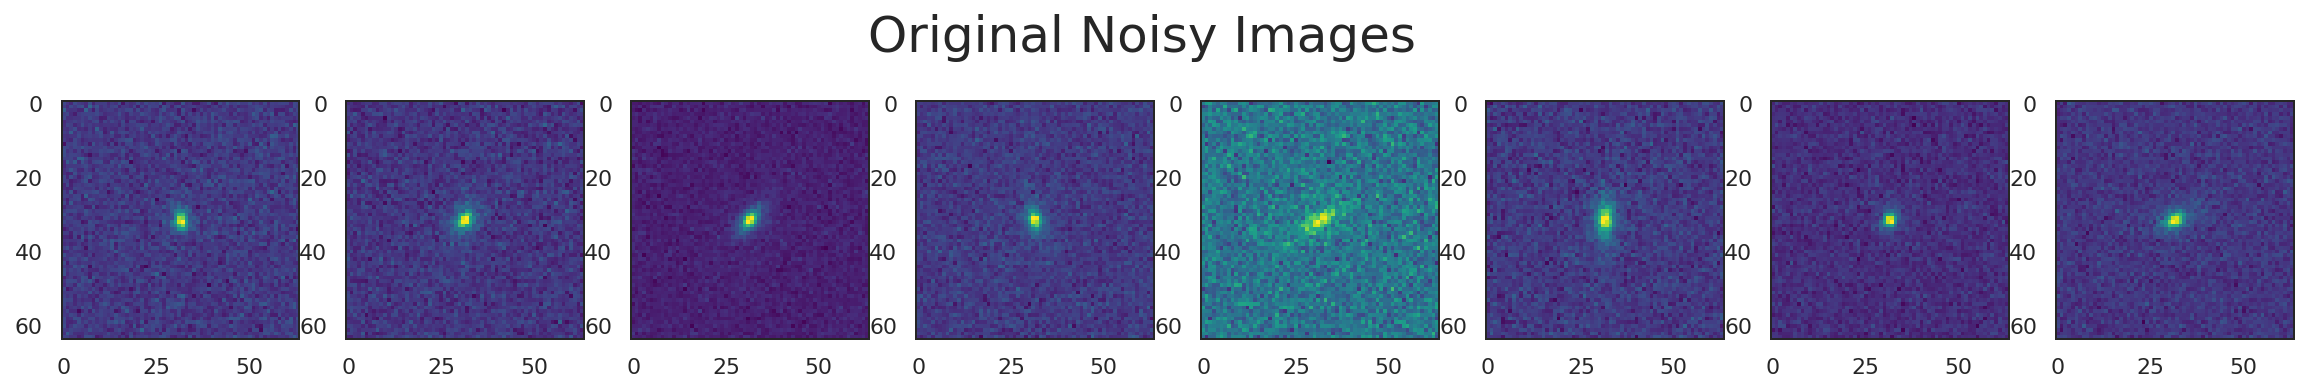

In [49]:
fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Clean Images", fontsize=25)
for j in range(8):
    ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
plt.show()

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Noisy Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [50]:
for i in idx:
    print("Pred:    ", tuple(pred_lab[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred_lab[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.1647152, 0.07182902, 0.2044045, 0.14926028, 0.5408108)
Orignal:  (0.17026287, 0.049049053, 0.18080983, 0.10208102, 0.6493643)
Error:    (-0.0055476725, 0.022779968, 0.023594677, 0.04717926, -0.10855347)

###########################################################################################

Pred:     (0.3263001, 0.5886941, 0.8145397, 0.38562393, 0.22240561)
Orignal:  (0.3362047, 0.5925926, 0.8538069, 0.34280568, 0.24744813)
Error:    (-0.009904593, -0.0038985014, -0.039267242, 0.04281825, -0.025042519)

###########################################################################################

Pred:     (0.5341734, 0.5694337, 0.57063913, 0.46601626, 0.05829999)
Orignal:  (0.51807296, 0.5695696, 0.5238198, 0.4018364, 0.055329215)
Error:    (0.016100466, -0.00013589859, 0.04681933, 0.06417987, 0.0029707737)

###########################################################################################

Pred:     (0.30623138, 0.70179534, 0.4694037, 0.0999144, 0.65728676)
O

<div class='gc'> <b> Variance Analysis </b> </div>

In [51]:
_, pred = reverse_AE.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (9123.122, 0.8382157, 0.051220797, 0.08575684, 0.08713056)
Unexplained Variance:  (0.012572076, 0.27712637, 0.13222212, 0.09610269, 0.09750125)
Explained Variance:    (0.98742795, 0.7228736, 0.8677779, 0.9038973, 0.9024987)


## <div class="theme"> End of Part 2 </div> 

## <div class="theme"> Part 3 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and variable PSF

### <div class='exercise'> <b> Step 1: Load the dataset with variable noise and variable PSF </b> </div>

In [52]:
# Read the data set
dataset = "./cs109b-project/data/data_v3.npz"

with np.load(dataset) as data:
    print("Available variables:", data.files)

    image = data["img"]
    image_nonoise = data["img_nonoise"]
    label = data["label"]
    snr = data["snr"]
    sigma = data["sigma"]
    psf = data["psf_r"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


<div class='gc'> <b> Join Sigma and PSF with the Label data </b> </div>

In [53]:
# Combine Singma and PSF with the label
# label = np.hstack([label, sigma.reshape(-1,1), psf.reshape(-1,1)])

### <div class='exercise'> <b> Step 2: Normalize the data and split the data into Traning and Validation sets </b> </div>

In [54]:
# Reshape images to 3D array
image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)


# Split into 90% train and 10% test (creates a view of the array)
n_train = int(label.shape[0] * 0.9)
image_train, image_val = image[:n_train], image[n_train:]
image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
label_train, label_val = label[:n_train], label[n_train:]
snr_train, snr_val = snr[:n_train], snr[n_train:]
sigma_train, sigma_val = sigma[:n_train], sigma[n_train:]
psf_train, psf_val = psf[:n_train], psf[n_train:]


# Zero-One Normalization of the labels
label_min = label.min(axis=0)
label_max = label.max(axis=0)
label_diff = np.maximum((label_max - label_min),1e-10)

label_train = (label_train - label_min)/label_diff
label_val = (label_val - label_min)/label_diff


# Zero-One Normalization of the no-noise images
image_nonoise_min = image_nonoise.min()
image_nonoise_max = image_nonoise.max()
image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


# Zero-One Normalization of the noisy images
image_min = image.min()
image_max = image.max()
image_diff = (image_max - image_min)

image_train = (image_train - image_min)/image_diff
image_val = (image_val - image_min)/image_diff


# Compute Image Statistics
stats = np.hstack([image.mean(axis=(1,2)).reshape(-1,1), image.std(axis=(1,2)).reshape(-1,1)])
stats_train, stats_val = stats[:n_train], stats[n_train:]

### <div class='exercise'> <b> Step 3: Structure and Size of the Data </b> </div>

In [55]:
# Structure and Size of the Data
print("Image Shape            = {}".format(image.shape))
print("No-noise Image Shape   = {}".format(image_nonoise.shape))
print("Label Shape            = {}".format(label.shape))
print("SNR Shape              = {}".format(snr.shape))
print("Sigma Shape            = {}".format(sigma.shape))
print("PSF-R Shape            = {}".format(psf.shape))
print("Stats Shape            = {}".format(stats.shape))

Image Shape            = (200000, 64, 64, 1)
No-noise Image Shape   = (200000, 64, 64, 1)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)
Stats Shape            = (200000, 2)


### <div class='exercise'> <b> Step 4: Create Data Pipeline </b> </div>

<div class='gc'> <b> Create Tensorflow Dataset </b> </div>

In [56]:
# Create Tensorflow Dataset
training = tf.data.Dataset.from_tensor_slices({
    "Image": image_train,
    "No-noise Image": image_nonoise_train,
    "Labels": label_train,
    "Stats": stats_train
})

validation = tf.data.Dataset.from_tensor_slices({
    "Image": image_val,
    "No-noise Image": image_nonoise_val,
    "Labels": label_val,
    "Stats": stats_val
})

<div class='gc'> <b> Define pipeline functions to structure dataset </b> </div>

In [57]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((label, stats), image)

In [58]:
def pipeline_noisy_image_to_label(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((image, stats), label)

In [59]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    clean = element['No-noise Image']
    
    return ((image, stats), (clean, label))

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [60]:
# Batch Size
batch_size = 256


# Data pipeline for Decoder
tr_ds = training.map(
    pipeline_label_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = validation.map(
    pipeline_label_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Data pipeline for Encoder
tr_ds_en = training.map(
    pipeline_noisy_image_to_label).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_en = validation.map(
    pipeline_noisy_image_to_label).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


# Data pipeline for AE
tr_ds_AE = training.map(
    pipeline_noisy_image_to_clean_image).shuffle(1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds_AE = validation.map(
    pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

### <div class='exercise'> <b> Step 6: Training Conditional Auto-encoder on Image Dataset with variable noise and fixed PSF</b> </div>

<div class='gc'> <b> Traning conditional decoder</b> </div>

In [61]:
# Run the model
try:
    reverse_decoder.load_weights('./model/rev_de6_3')
    print("Training Loss:   {:0.5f}".format(reverse_decoder.evaluate(tr_ds)))
    print("Validation Loss: {:0.5f}".format(reverse_decoder.evaluate(val_ds)))
    
except:
    history = reverse_decoder.fit(
        tr_ds, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_decoder.save_weights('./model/rev_de6_3')

Epoch 1/50
704/704 [==============================] - 168s 239ms/step - loss: 0.0126 - val_loss: 0.0000e+00
Epoch 2/50
704/704 [==============================] - 167s 238ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 3/50
704/704 [==============================] - 169s 239ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 4/50
704/704 [==============================] - 169s 240ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 5/50
704/704 [==============================] - 165s 234ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 6/50
704/704 [==============================] - 167s 237ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 7/50
704/704 [==============================] - 169s 241ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 8/50
704/704 [==============================] - 169s 240ms/step - loss: 0.0126 - val_loss: 0.0126


<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [62]:
test = val_ds.take(1)
labels, images = next(iter(test))
pred = reverse_decoder.predict(labels)
pred = pred.reshape(pred.shape[:-1])

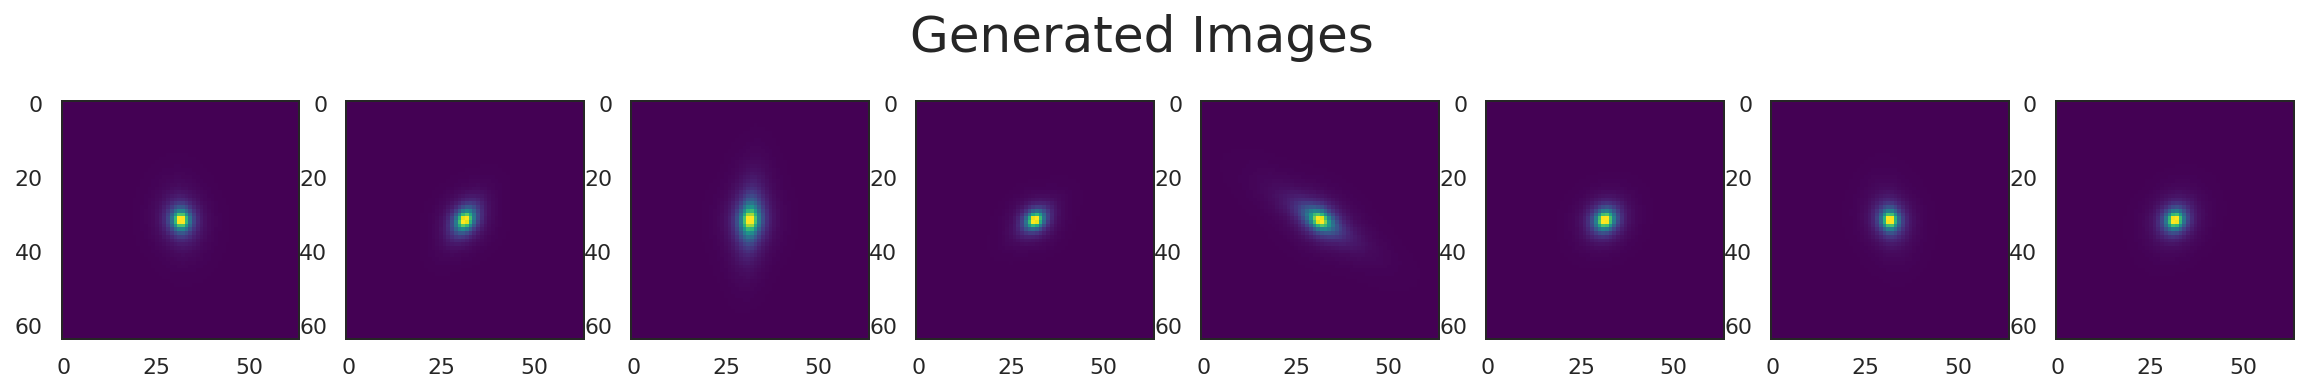

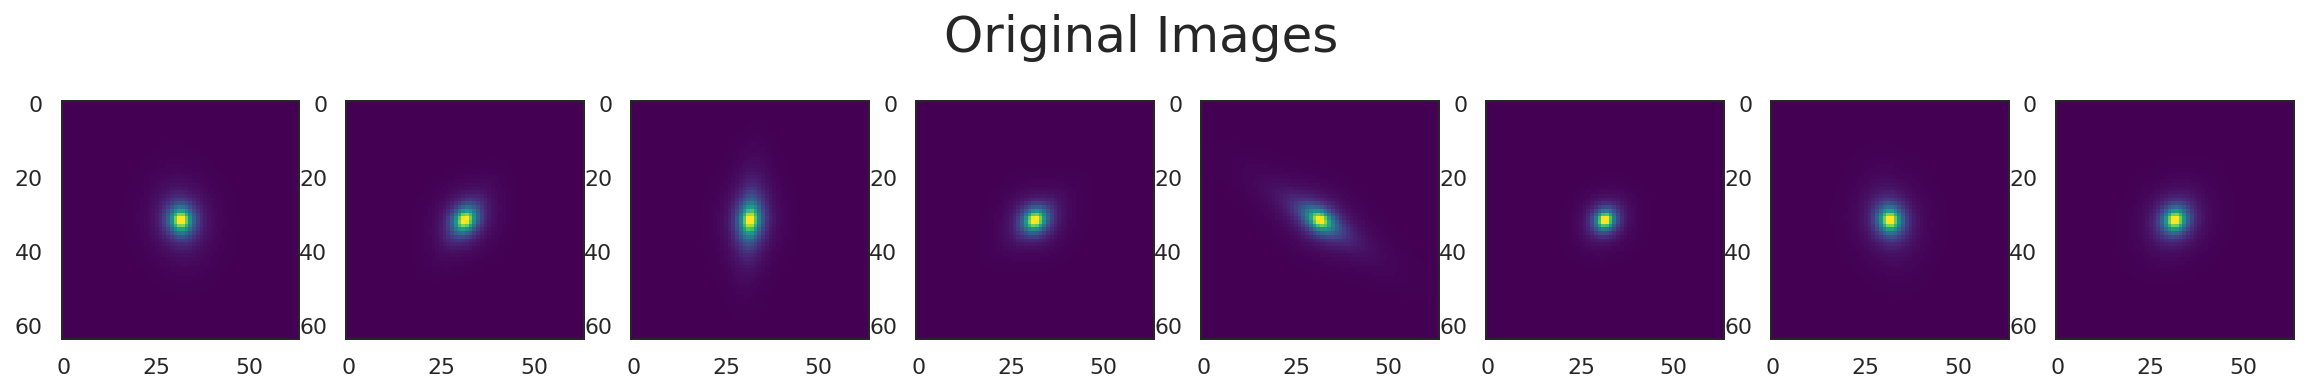

In [63]:
idx = np.random.randint(256*1, size=8)

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Traning conditional encoder</b> </div>

In [64]:
# Run the model
try:
    reverse_encoder.load_weights('./model/rev_en6_3')
    print("Training Loss:   {:0.5f}".format(reverse_encoder.evaluate(tr_ds_en)))
    print("Validation Loss: {:0.5f}".format(reverse_encoder.evaluate(val_ds_en)))
    
except:
    history = reverse_encoder.fit(
        tr_ds_en, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_en,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_encoder.save_weights('./model/rev_en6_3')

Epoch 1/50
704/704 [==============================] - 158s 225ms/step - loss: 0.6052 - val_loss: 0.0000e+00
Epoch 2/50
704/704 [==============================] - 157s 224ms/step - loss: 0.5997 - val_loss: 0.5965
Epoch 3/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5981 - val_loss: 0.5947
Epoch 4/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5970 - val_loss: 0.5937
Epoch 5/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5962 - val_loss: 0.5932
Epoch 6/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5956 - val_loss: 0.5933
Epoch 7/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5951 - val_loss: 0.5929
Epoch 8/50
704/704 [==============================] - 157s 223ms/step - loss: 0.5948 - val_loss: 0.5933
Epoch 9/50
704/704 [==============================] - 158s 224ms/step - loss: 0.5946 - val_loss: 0.5949
Epoch 10/50
704/704 [==============================] - 157s 

<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [65]:
test = val_ds_en.take(1)
images, labels = next(iter(test))
pred = reverse_encoder.predict(images)

In [66]:
np.set_printoptions(suppress=True)

for i in idx:
    print("Pred:    ", tuple(pred[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.55490404, 0.48944744, 0.65285325, 0.17945859, 0.6095983)
Orignal:  (0.5508298, 0.7747748, 0.40415874, 0.2648843, 0.57189256)
Error:    (0.004074216, -0.28532735, 0.24869451, -0.085425705, 0.03770572)

###########################################################################################

Pred:     (0.39002535, 0.51246554, 0.6039294, 0.34592265, 0.30427212)
Orignal:  (0.33818236, 0.3833834, 0.3673788, 0.37135658, 0.150555)
Error:    (0.051842988, 0.12908214, 0.2365506, -0.025433928, 0.15371712)

###########################################################################################

Pred:     (0.86001575, 0.4179557, 0.8641833, 0.053298265, 0.45974913)
Orignal:  (0.82859594, 0.26226225, 0.85082084, 0.04456085, 0.43273693)
Error:    (0.031419814, 0.15569344, 0.013362467, 0.008737415, 0.0270122)

###########################################################################################

Pred:     (0.16453454, 0.579498, 0.5516384, 0.47755948, 0.3738914)
Orignal:  (0.1

<div class='gc'> <b> Variance Analysis </b> </div>

In [67]:
pred = reverse_encoder.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (11025.028, 1.1083752, 0.094966196, 0.11278047, 0.114232704)
Unexplained Variance:  (0.01376116, 0.48455134, 0.44740534, 0.16865239, 0.17238645)
Explained Variance:    (0.98623884, 0.5154487, 0.55259466, 0.8313476, 0.82761353)


<div class='gc'> <b> Finetuning Conditional Auto-encoder </b> </div>

In [68]:
# Run the model
try:
    reverse_AE.load_weights('./model/rev_AE6_3')
    print("Training Loss:   {}".format(reverse_AE.evaluate(tr_ds_AE)))
    print("Validation Loss: {}".format(reverse_AE.evaluate(val_ds_AE)))
    
except:
    history = reverse_AE.fit(
        tr_ds_AE, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_AE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_AE.save_weights('./model/rev_AE6_3')

Epoch 1/50
704/704 [==============================] - 328s 465ms/step - loss: 0.6064 - Reverse_Decoder_loss: 0.0126 - Reverse_Encoder_loss: 0.5937 - val_loss: 0.0000e+00 - val_Reverse_Decoder_loss: 0.0000e+00 - val_Reverse_Encoder_loss: 0.0000e+00
Epoch 2/50
704/704 [==============================] - 325s 462ms/step - loss: 0.6056 - Reverse_Decoder_loss: 0.0126 - Reverse_Encoder_loss: 0.5930 - val_loss: 0.6043 - val_Reverse_Decoder_loss: 0.0126 - val_Reverse_Encoder_loss: 0.5917
Epoch 3/50
704/704 [==============================] - 325s 461ms/step - loss: 0.6053 - Reverse_Decoder_loss: 0.0126 - Reverse_Encoder_loss: 0.5926 - val_loss: 0.6050 - val_Reverse_Decoder_loss: 0.0126 - val_Reverse_Encoder_loss: 0.5924
Epoch 4/50
704/704 [==============================] - 325s 462ms/step - loss: 0.6051 - Reverse_Decoder_loss: 0.0126 - Reverse_Encoder_loss: 0.5925 - val_loss: 0.6033 - val_Reverse_Decoder_loss: 0.0126 - val_Reverse_Encoder_loss: 0.5908
Epoch 5/50
704/704 [========================

ResourceExhaustedError: model/rev_AE6_3_temp_2849e882da44463eb302abaa998dd6a8/part-00001-of-00002.data-00000-of-00001.tempstate14190705537568485438; No space left on device [Op:SaveV2]

<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [72]:
test = val_ds_AE.take(1)
(images, stats), (clean, labels) = next(iter(test))
pred_img, pred_lab = reverse_AE.predict([images, stats])
pred = pred_img.reshape(pred_img.shape[:-1])

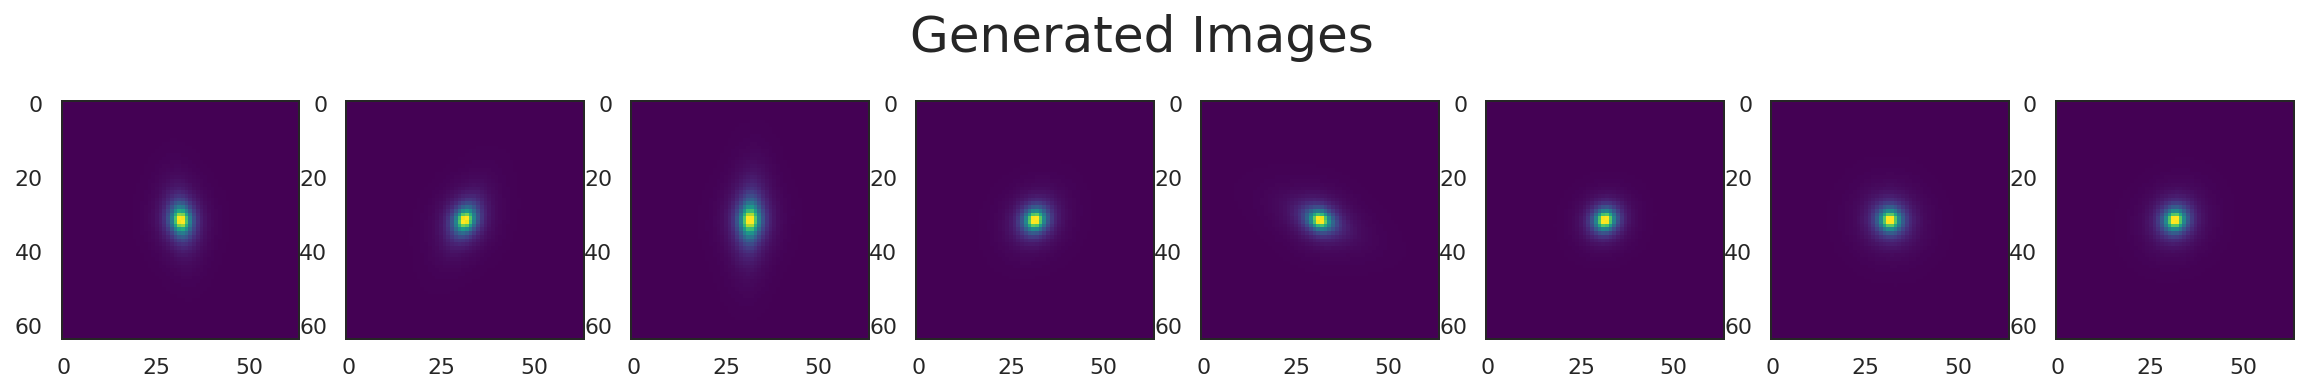

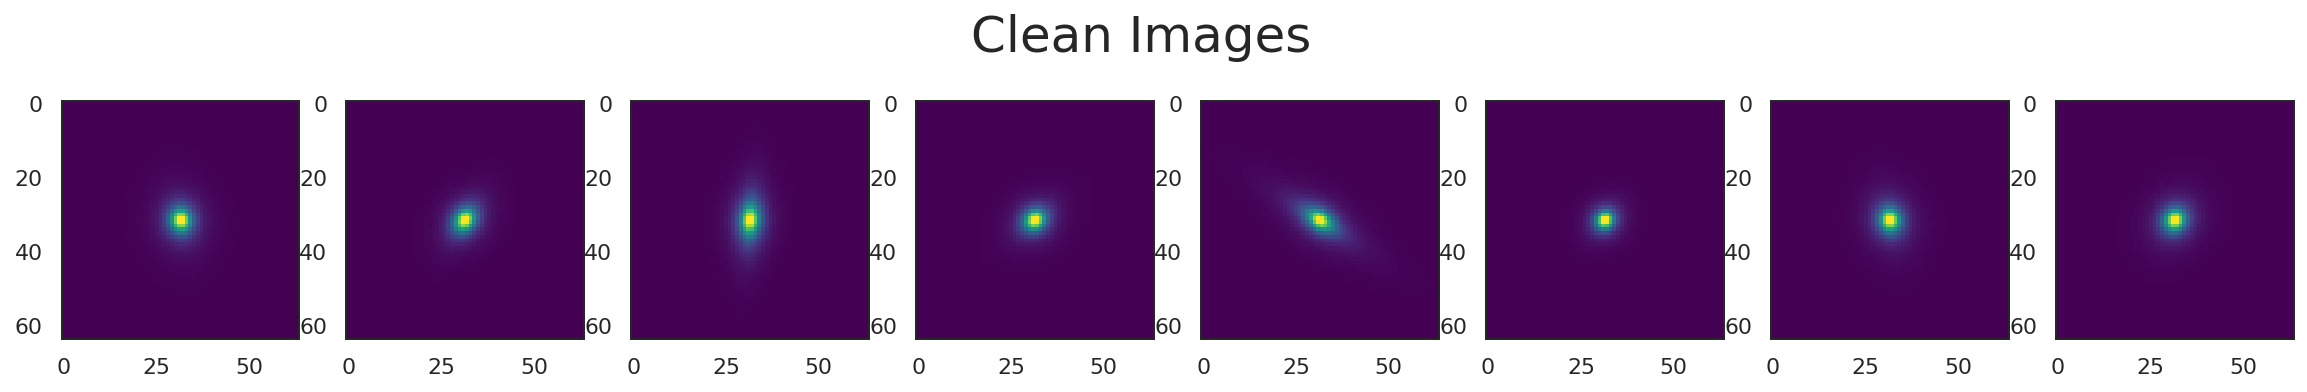

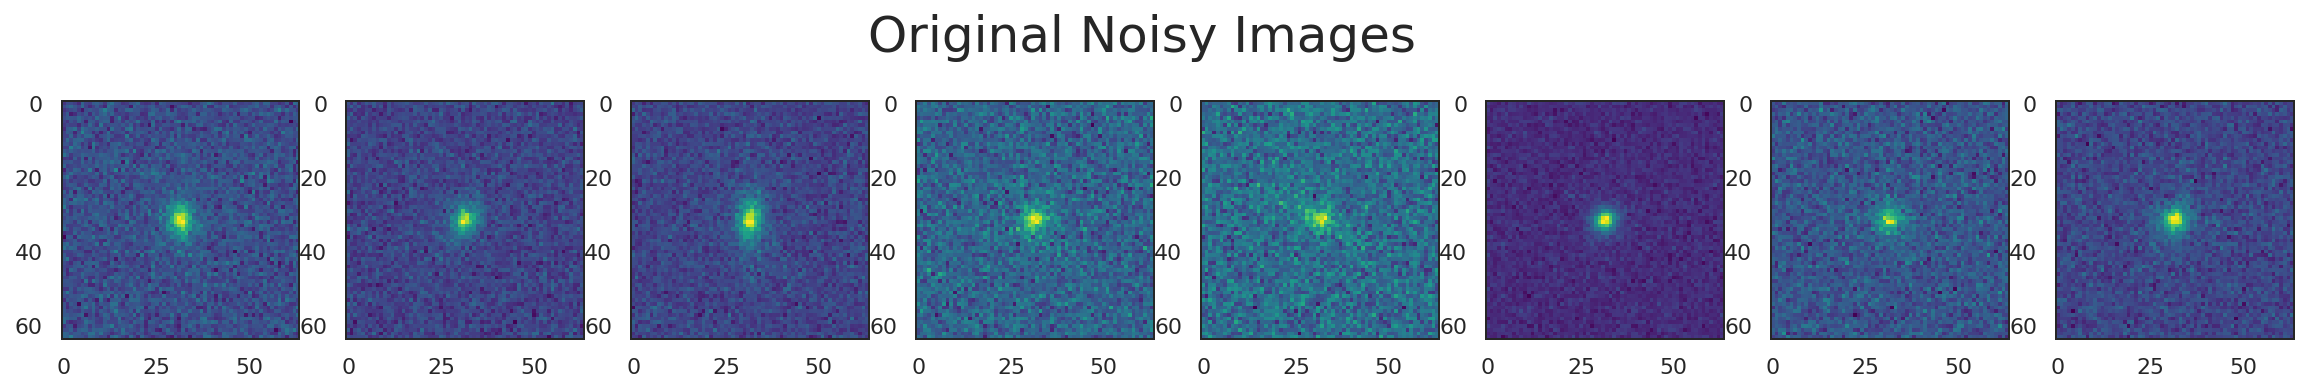

In [73]:
fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Clean Images", fontsize=25)
for j in range(8):
    ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
plt.show()

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Noisy Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [74]:
for i in idx:
    print("Pred:    ", tuple(pred_lab[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred_lab[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

Pred:     (0.5672095, 0.40954792, 0.5910634, 0.15009186, 0.5963262)
Orignal:  (0.5508298, 0.7747748, 0.40415874, 0.2648843, 0.57189256)
Error:    (0.016379654, -0.36522686, 0.18690464, -0.11479244, 0.024433613)

###########################################################################################

Pred:     (0.4057461, 0.54701316, 0.5812928, 0.31356364, 0.2628101)
Orignal:  (0.33818236, 0.3833834, 0.3673788, 0.37135658, 0.150555)
Error:    (0.06756374, 0.16362977, 0.213914, -0.05779293, 0.11225511)

###########################################################################################

Pred:     (0.8798411, 0.31733868, 0.85447466, 0.040183723, 0.45203525)
Orignal:  (0.82859594, 0.26226225, 0.85082084, 0.04456085, 0.43273693)
Error:    (0.051245153, 0.05507642, 0.0036538243, -0.0043771267, 0.019298315)

###########################################################################################

Pred:     (0.1473118, 0.5649517, 0.48092312, 0.46268526, 0.34445748)
Orignal:  (0.

<div class='gc'> <b> Variance Analysis </b> </div>

In [75]:
_, pred = reverse_AE.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

RMSE:                  (10950.475, 1.0753627, 0.09328533, 0.109817855, 0.1106919)
Unexplained Variance:  (0.013575678, 0.4561169, 0.43170774, 0.15990816, 0.16186534)
Explained Variance:    (0.9864243, 0.5438831, 0.56829226, 0.8400918, 0.83813465)


## <div class="theme"> End of Part 3 </div> 

## <div class="theme"> Part 4 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and PSF - Direct Learning with MSE Loss

<div class='gc'> <b> Create a Conditional Auto-encoder </b> </div>

In [ ]:
# Start a new session
K.clear_session()

# Create a conditional autoencoder
reverse_decoder = create_reverse_decoder()
reverse_encoder = create_reverse_encoder()
reverse_AE = create_reverse_AE()

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
reverse_AE.compile(optimizer, loss=losses.MeanSquaredError())

<div class='gc'> <b> Train Conditional Auto-encoder </b> </div>

In [ ]:
# Run the model
try:
    reverse_AE.load_weights('./model/rev_AE6_4')
    print("Training Loss:   {}".format(reverse_AE.evaluate(tr_ds_AE)))
    print("Validation Loss: {}".format(reverse_AE.evaluate(val_ds_AE)))
    
except:
    history = reverse_AE.fit(
        tr_ds_AE, 
        epochs=epochs, 
        verbose=1,
        validation_data=val_ds_AE,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    reverse_AE.save_weights('./model/rev_AE6_4')

<div class='gc'> <b> Generating reconstructed images from labels for visual inspection </b> </div>

In [ ]:
test = val_ds_AE.take(1)
(images, stats), (clean, labels) = next(iter(test))
pred_img, pred_lab = reverse_AE.predict([images, stats])
pred = pred_img.reshape(pred_img.shape[:-1])

In [ ]:
fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Generated Images", fontsize=25)
for j in range(8):
    ax[j].imshow(pred[idx[j]])
plt.show()


fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Clean Images", fontsize=25)
for j in range(8):
    ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
plt.show()

fig, ax = plt.subplots(1,8, figsize=(20,3))
plt.suptitle("Original Noisy Images", fontsize=25)
for j in range(8):
    ax[j].imshow(images[idx[j]].numpy().reshape(64,64))
plt.show()

<div class='gc'> <b> Generating labels from noisy images for visual inspection </b> </div>

In [ ]:
for i in idx:
    print("Pred:    ", tuple(pred_lab[i]))
    print("Orignal: ", tuple(labels[i].numpy()))
    print("Error:   ", tuple(pred_lab[i]-labels[i].numpy()))
    print("\n###########################################################################################\n")

<div class='gc'> <b> Variance Analysis </b> </div>

In [ ]:
_, pred = reverse_AE.predict(val_ds_en)
error_unscaled = (pred - label_val) * label_diff

MSE = (error_unscaled**2).mean(axis=0)
RMSE = np.sqrt(MSE)

label_var = (label_val.std(axis=0) * label_diff)**2

unexplained_var = MSE/np.maximum(label_var, 1e-10)

print("RMSE:                  {}".format(tuple(RMSE)))
print("Unexplained Variance:  {}".format(tuple(unexplained_var)))
print("Explained Variance:    {}".format(tuple(1-unexplained_var)))

## <div class="theme"> End of Part 4 </div> 

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End Of Project
